In [1]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from paper_visualizations import * 
from PixelEM import * 
# from test_sample import test_sample_obj
import json

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Cluster-based majority vote

In [81]:
MV = pd.read_csv("pixel_em/MV_PRJ_table.csv")
MV["clust"]=-1
MV_clust = pd.read_csv("pixel_em/withClust_MV_PRJ_table.csv",index_col=0)
MV_clust["num_workers"] = MV_clust["sample"].apply(lambda x: int(x.split("workers")[0]))
MV_clust["sample_num"] = MV_clust["sample"].apply(lambda x: int(x.split("rand")[-1]))
MV_clust = MV_clust.drop("sample",axis=1)
MV_df = pd.concat([MV_clust,MV])
MV_df.to_csv("pixel_em/all_MV_PRJ_table.csv")

# picking best workers based on heuristics

We are using ~~highest count of cluster~~ best MV to figure out what is the best cluster

In [86]:
# MV_df.loc[MV_df.groupby(['objid','num_workers','sample_num'])["MV_jaccard"].idxmax()]

In [87]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
#pick the cluster with the highest count
# clust_df["count"]=clust_df.groupby(['objid','cluster']).transform("count")
# clust_df=clust_df.drop('wid',axis=1)
# best_clust_df = clust_df.loc[clust_df.groupby(['objid'])["count"].idxmax()]
# best_clust_df = best_clust_df.drop(["count"],axis=1)
# pick the cluster with the highest MV
best_clust_df = MV_clust.loc[MV_clust.groupby(["sample_num","num_workers","objid"])["MV_jaccard"].idxmax()]
best_clust_df = best_clust_df.drop(['MV_precision','MV_recall','MV_jaccard'],axis=1)

object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
noClust_obj =[obj for obj in object_lst if obj not in clust_df.objid.unique() ]
# noClust_df = pd.DataFrame(zip(noClust_obj,list(-1*np.ones_like(noClust_obj))),columns=["objid","clust"])
# clust_df = pd.concat([best_clust_df,noClust_df])
best_clust_df = best_clust_df.rename(columns={'cluster':'clust'})

In [88]:
#clust_df.sort("objid") # table summarizing which cluster to pick for which object

# With Cluster Analysis

In [89]:
df = pd.read_csv("pixel_em/all_MV_PRJ_table.csv")
df = df.rename(columns={"MV_precision":"P [MV]",
                       "MV_recall":"R [MV]",
                       "MV_jaccard":"J [MV]"})
for mode in  ["GT","isoGT","GTLSA","isoGTLSA","basic"]:
    data =  pd.read_csv("pixel_em/{}_ground_truth_full_PRJ_table.csv".format(mode))
    data = data.rename(columns={"EM_precision":"P [{}]".format(mode),
                       "EM_recall":"R [{}]".format(mode),
                       "EM_jaccard":"J [{}]".format(mode),})
    df = df.merge(data)

In [90]:
metric_keys=[u'P [MV]',u'R [MV]', u'J [MV]', u'P [GT]', u'R [GT]', u'J [GT]', u'P [isoGT]',
       u'R [isoGT]', u'J [isoGT]', u'P [GTLSA]', u'R [GTLSA]', u'J [GTLSA]',
       u'P [isoGTLSA]', u'R [isoGTLSA]', u'J [isoGTLSA]', u'P [basic]',
       u'R [basic]', u'J [basic]']

#### Extracting important clusters only

In [94]:
metric_J= [u'J [MV]', u'J [GT]', u'J [isoGT]', u'J [GTLSA]', u'J [isoGTLSA]', u'J [basic]']
# df["J [avrg]"]=df[metric_J].mean(axis=1)
#best_thres_best_clust_df = df.loc[df.groupby(['num_workers','sample_num','objid'])["J [avrg]"].idxmax()]
#best_clust_no_thresh_df = df.merge(clust_df) #pick only the clusters that are in the best clusters
# pick rows based on whether it is in clust_df or not
keys  = list(best_clust_df.columns)
i1 = df.set_index(keys).index
i2 = best_clust_df.set_index(keys).index
best_clust_no_thresh_df = df[(~i1.isin(i2))|(df.clust==-1)]

### Performance as it varies with number of workers

In [95]:
Nworker_performance = best_thres_best_clust_df.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
#    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

NameError: name 'best_thres_best_clust_df' is not defined

In [96]:
print "isoGTLSA_best_clust_thresh=",list(Nworker_performance['J [isoGTLSA]'])
print "isoGT_best_clust_thresh=",list(Nworker_performance['J [isoGT]'])
print "MV_best_clust_thresh=", list(Nworker_performance['J [MV]'])

isoGTLSA_best_clust_thresh= [0.81762327438040205, 0.80754532914942001, 0.80242171681684027, 0.79601941134337595, 0.78349460673096261, 0.78803889936893856]
isoGT_best_clust_thresh= [0.8264871215647438, 0.8278941926311647, 0.82236138559584782, 0.81931400838469981, 0.81586841659722897, 0.81616633656360393]
MV_best_clust_thresh= [0.70696810055905757, 0.6719632316711841, 0.65965928131471796, 0.57949980746077845, 0.55006170886846928, 0.55093967937503219]


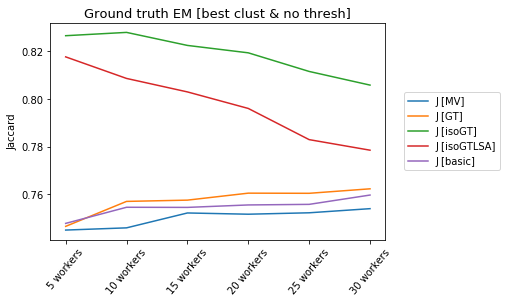

In [99]:
Nworker_performance = best_clust_no_thresh_df.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude *GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & no thresh]",fontsize=13)

In [54]:
best_clust_no_thresh_df[best_clust_no_thresh_df["num_workers"]==30]

,Unnamed: 0,J [MV],P [MV],R [MV],clust,num_workers,objid,sample_num,thresh,P [GT],...,J [isoGT],P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic]
6100,1220,0.000000,-1.000000,0.000000,1,30,1,0,-4,0.085234,...,0.804449,0.085234,1.000000,0.085234,0.804449,1.000000,0.804449,0.911623,0.195005,0.191386
6101,1220,0.000000,-1.000000,0.000000,1,30,1,0,-2,0.085234,...,0.804449,0.085172,0.999198,0.085166,0.804347,0.999198,0.803828,0.911623,0.195005,0.191386
6102,1220,0.000000,-1.000000,0.000000,1,30,1,0,0,0.911623,...,0.191386,0.085172,0.999198,0.085166,0.813312,0.992629,0.808429,0.978124,0.189543,0.188743
6103,1220,0.000000,-1.000000,0.000000,1,30,1,0,2,0.911623,...,0.188743,0.911454,0.194203,0.190606,0.980834,0.187634,0.186948,0.980804,0.187328,0.186644
6104,1220,0.000000,-1.000000,0.000000,1,30,1,0,4,0.911623,...,0.165559,0.980834,0.187634,0.186948,0.980834,0.187634,0.186948,0.980804,0.187328,0.186644
6110,1222,0.000000,-1.000000,0.000000,1,30,4,0,-4,0.431032,...,0.422387,0.010676,0.993636,0.010675,0.422839,0.993030,0.421588,0.431032,0.955455,0.422541
6111,1222,0.000000,-1.000000,0.000000,1,30,4,0,-2,0.431032,...,0.422541,0.010676,0.993636,0.010675,0.438233,0.973939,0.433154,0.431032,0.955455,0.422541
6112,1222,0.000000,-1.000000,0.000000,1,30,4,0,0,0.431032,...,0.432050,0.010602,0.986667,0.010601,0.438233,0.973939,0.433154,0.447659,0.933030,0.433723
6113,1222,0.000000,-1.000000,0.000000,1,30,4,0,2,0.447770,...,0.783343,0.447770,0.924848,0.432050,0.881714,0.835758,0.751499,0.447770,0.924848,0.432050
6114,1222,0.000000,-1.000000,0.000000,1,30,4,0,4,0.447770,...,0.783343,0.447770,0.924848,0.432050,0.994636,0.786667,0.783343,0.447770,0.924848,0.432050


In [53]:
def plot_PRcurve(objid,num_worker,sample_num=0):
    objdf = df[(df["num_workers"]==num_worker)&(df["sample_num"]==sample_num)&(df["objid"]==objid)]
    plt.figure()
    for algo in ['basic','GT','isoGT','GTLSA','isoGTLSA']:
        x= objdf["P [{}]".format(algo)]
        y = objdf["R [{}]".format(algo)]
        if len(x)<=0:
            return
        sortedx, sortedy = zip(*sorted(zip(x, y)))
        plt.plot(sortedx,sortedy,'.-',label=algo)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    plt.legend(loc="bottom left")
    plt.title("{}worker_rand{} [obj {};N={}]".format(num_worker,sample_num,objid,len(objdf)))

# Greedy Algo Results

In [125]:
from greedyPicking import *

In [126]:
from glob import glob 
import pandas as pd

globfnames = glob("withClust_greedy_result_*.csv")
globfnames.remove('withClust_greedy_result_worker_fraction.csv')
greedy_df = pd.read_csv(globfnames[0],index_col=0)
for fname in globfnames[1:]: 
    greedy_df = greedy_df.append(pd.read_csv(fname,index_col=0))

#assert len(greedy_df)==31*44*5

greedy_df.to_csv("withClust_all_greedy_result.csv")

In [127]:
greedy_df = pd.read_csv("withClust_all_greedy_result.csv",index_col=0)
ground_truth_greedy_df = pd.read_csv("ground_truth_greedy_result.csv")
ground_truth_greedy_df["cluster_id"] = -1
# greedy_df = greedy_df.append(ground_truth_greedy_df)

worker_frac_greedy_df = pd.read_csv("withClust_greedy_result_worker_fraction.csv")
noClust_worker_frac_greedy_df = pd.read_csv("greedy_old_results/greedy_result_worker_fraction.csv")
noClust_worker_frac_greedy_df["cluster_id"]=-1
# greedy_df = greedy_df.append(worker_frac_greedy_df)
greedy_df=pd.concat([greedy_df,ground_truth_greedy_df,worker_frac_greedy_df,noClust_worker_frac_greedy_df])
greedy_df["num_workers"] = greedy_df["sample"].apply(lambda x: int(x.split("workers")[0]))

In [128]:
noClust_greedy = pd.read_csv("greedy_old_results/all_greedy_result.csv",index_col=0)
noClust_greedy["cluster_id"]=-1
noClust_greedy["num_workers"] = noClust_greedy["sample"].apply(lambda x: int(x.split("workers")[0]))
greedy_df = pd.concat([greedy_df,noClust_greedy,])

In [129]:
# greedy_df.groupby(['sample','objid','cluster_id','algo']).mean()

In [130]:
best_thres_clust = greedy_df.loc[greedy_df.groupby(['sample','objid','cluster_id'])["j"].idxmax()]

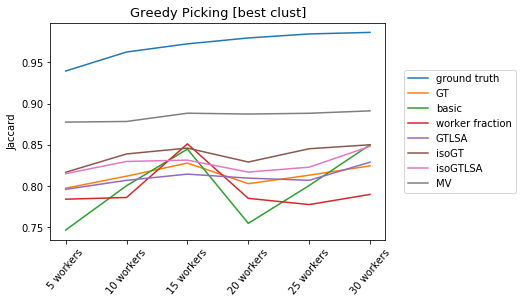

In [131]:
Nworker_performance = best_thres_clust.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking [best clust]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [134]:
print "greedy_ground_truth=",list(Nworker_performance[Nworker_performance["algo"]=="ground truth"]['j'])
print "greedy_best_clust_isoGT_best_clust=",list(Nworker_performance[Nworker_performance["algo"]=="isoGT"]['j'])
print "greedy_best_clust_worker_frac_best_clust=",list(Nworker_performance[Nworker_performance["algo"]=="worker fraction"]['j'])

greedy_ground_truth= [0.93945579463386852, 0.96266602709650861, 0.97255700868926886, 0.97965396048192555, 0.98286834173734094, 0.9863217494865455]
greedy_best_clust_isoGT_best_clust= [0.89798084966980929, 0.90172692332783833, 0.90115935241699163, 0.91026799603210795, 0.90811380044456835, 0.91080227077649989]
greedy_best_clust_worker_frac_best_clust= [0.87059208586784431, 0.88653805811473196, 0.88572357142652258, 0.88768491119243764, 0.88774048826785179, 0.88989101610129528]


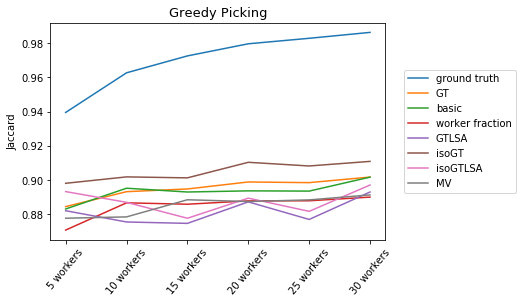

In [133]:
noClust_greedy_df = greedy_df[greedy_df["cluster_id"]==-1]

Nworker_performance = noClust_greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


### Compare between best thresh, best cluster thresh, no filtering

In [149]:
isoGT= [0.86180714318405227, 0.8988109346737535, 0.90404005468171478, 0.90954740011618374, 0.90776463234071514, 0.91052706488955748]
isoGT_best_thresh= [0.88030482691468614, 0.90370402275291195, 0.90762227879598867, 0.91135894959171038, 0.90901508399830366, 0.91165606774023689]
isoGT_best_clust_thresh= [0.89053582642892704, 0.91043263143527653, 0.91072460538463296, 0.91298553956838557, 0.9133358038218542, 0.91395674303385022]

isoGTLSA= [0.86001952128075243, 0.8852958258350111, 0.88859038520376588, 0.89840505843053553, 0.89202225166859883, 0.90219252902030678]
isoGTLSA_best_clust_thresh= [0.88689167180043649, 0.91048138225685693, 0.91299126179100099, 0.91512888607542109, 0.91541973994201986, 0.91610285869121277]
isoGTLSA_best_thresh= [0.87519051694562056, 0.8998780616894021, 0.90556915704845498, 0.9106581626726421, 0.90980669965364624, 0.911292941153929]

MV=[0.87752629669525561, 0.87830363026608183, 0.88833647762838908, 0.88730470573821674, 0.88825327097293416, 0.89117292810808058]

greedy_ground_truth= [0.93951474621942344, 0.96259939450243182, 0.97248527408043894, 0.97963366947487251, 0.98449873027478896, 0.98638885982213032]
greedy_best_clust_ground_truth= [0.93951474621942344, 0.96259939450243182, 0.97248527408043894, 0.97963366947487251, 0.98449873027478896, 0.98638885982213032]
greedy_best_clust_isoGT_best_clust= [0.81666471632318671, 0.83889938832313449, 0.84600792782630796, 0.82911366669473552, 0.84518859314462635, 0.85003625101149749]
greedy_best_clust_worker_frac_best_clust= [0.78398373054021864, 0.78606556755405699, 0.85113902106882366, 0.78499711065345612, 0.77747321106591438, 0.78978937616783218]
greedy_isoGT_no_clust= [0.89798084966980929, 0.90172692332783833, 0.90115935241699163, 0.91026799603210795, 0.90811380044456835, 0.91080227077649989]
greedy_worker_frac_no_clust= [0.87059208586784431, 0.88653805811473196, 0.88572357142652258, 0.88768491119243764, 0.88774048826785179, 0.88989101610129528]

In [150]:
algoDict=[{"val":isoGT,"name":'Best no clust, no thresh [isoGT]','color':"blue",'linestyle':"-."},
    {"val":isoGT_best_thresh,"name":'Best no clust, with thresh [isoGT]','color':"blue",'linestyle':"--"},
    {"val":isoGT_best_clust_thresh,"name":'Best with clust, with thresh [isoGT]','color':"blue",'linestyle':"-"},
          
    {"val":isoGTLSA,"name":'Best no clust, no thresh [isoGTLSA]','color':"red",'linestyle':"-."},
    {"val":isoGTLSA_best_thresh,"name":'Best no clust, with thresh [isoGTLSA]','color':"red",'linestyle':"--"},
    {"val":isoGTLSA_best_clust_thresh,"name":'Best with clust, with thresh [isoGTLSA]','color':"red",'linestyle':"-"},
          
    {"val":MV,"name":'MV','color':"gray",'linestyle':"-"},
]

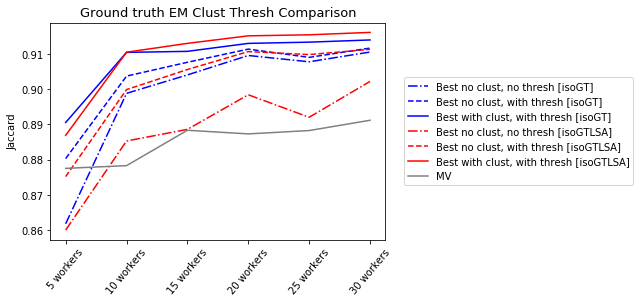

In [151]:
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)

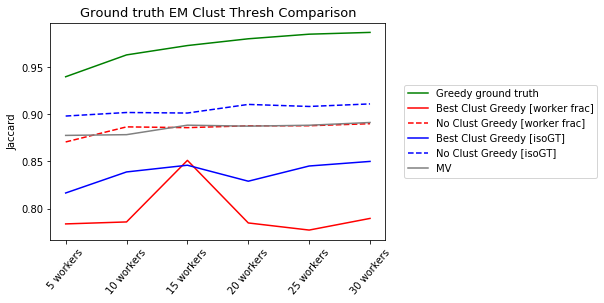

In [153]:
algoDict=[{"val":greedy_ground_truth,"name":'Greedy ground truth','color':"green",'linestyle':"-"},
    #neon green
    {"val":greedy_worker_frac_best_clust,"name":'Best Clust Greedy [worker frac]','color':"red",'linestyle':"-"},
    {"val":greedy_worker_frac_no_clust,"name":'No Clust Greedy [worker frac]','color':"red",'linestyle':"--"},

    {"val":greedy_isoGT_best_clust,"name":'Best Clust Greedy [isoGT]','color':"blue",'linestyle':"-"},
    {"val":greedy_isoGT_no_clust,"name":'No Clust Greedy [isoGT]','color':"blue",'linestyle':"--"},

    {"val":MV,"name":'MV','color':"gray",'linestyle':"-"},
]
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)

To do 
- pick MV only based on best workers
- Determine best cluster by heuristic of number of annotations in that cluster. 